In [ ]:
import pandas as pd
import numpy as np
from functools import reduce
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import geopandas as gpd
import pysal
from pysal import model
from libpysal.weights import KNN
from libpysal.weights import lag_spatial
from esda.moran import Moran

## Before Regression

In [3]:
useful_detector_530 = pd.read_csv('data/detector_530.csv')

In [4]:
POI = pd.read_csv('../POI/all_buffer_POI_percent.csv')
landcover = pd.read_csv('../Land_cover/all_buffer_landcover_percent_new.csv')
census = pd.read_csv('../Social-demongraphic/all_buffer_census_percent.csv')
road = pd.read_csv('../Glasgow_road_link-shp/all_buffer_road_percent.csv')
GSV = pd.read_csv('../Google Street View/semantic segmentation model/latest_segmentation_normalisation_output_before_2021-12-31.csv')

## 1. Prepare the dependent variable

### 1.1 Clean the error dates, get date,week&month

In [77]:
def data_clean(data, error_dates):

    data['date'] = data['lastUpdate'].str.split('T').str[0]
    data['month'] = data['date'].str.split("-").str[0] + '-' + data['date'].str.split("-").str[1]
    
    pd_date = pd.to_datetime(data['date']) #convert to pandas date
    data['week'] = pd_date.dt.isocalendar().year.astype(str) + '-' + pd_date.dt.isocalendar().week.astype(str)
    #data = data[['date', 'lastUpdate', 'timestamp', 'siteSiteid', 'count', 'originDescription', 'flow', 'concentration']]
    
    for i in error_dates.errorDates.tolist():
        data = data.drop(data.loc[data['date']==i].index)
    
    data2 = data.sort_values(by=['lastUpdate'])
    data2 = data2.reset_index(drop=True)
    
    return data2

### 1.2 Delete all zero from original data

In [6]:
def drop_zero_flow(data2):
    data2 = data2[data2['flow'] != 0]
    
    data3 = data2.sort_values(by=['lastUpdate'])
    data3 = data3.reset_index(drop=True)

    return data3

### 1.3 Get the average traffic flow 

In [217]:
def get_daily_average_flow(data2):

    date_list = list(set(data2.date))
    #print(sorted(date_list))

    flow_list_daily = []
    for i in date_list:
        b = data2.loc[data2.date == i, 'flow'].sum()
        #print(b)
        flow_list_daily.append(b)
        
    daily_average_flow = sum(flow_list_daily) / len(flow_list_daily)
    
    return daily_average_flow

### 1.4 Add COVID stage to the data

In [220]:
def add_stage(data3):

    first_from_index_1 = data3[data3.date=='2019-08-09'].first_valid_index()
    last_to_index_1 = data3[data3.date=='2019-10-16'].last_valid_index()
    
    first_from_index_2 = data3[data3.date=='2020-03-24'].first_valid_index()
    last_to_index_2 = data3[data3.date=='2020-05-28'].last_valid_index()
    
    first_from_index_3 = data3[data3.date=='2021-01-06'].first_valid_index()
    last_to_index_3 = data3[data3.date=='2021-03-13'].last_valid_index()
    
    first_from_index_4 = data3[data3.date=='2021-08-09'].first_valid_index()
    last_to_index_4 = data3[data3.date=='2021-10-16'].last_valid_index()
    
    data3['stage'] = 'Other'
    data3.loc[first_from_index_1 : last_to_index_1, 'stage'] = 'Before COVID'
    data3.loc[first_from_index_2 : last_to_index_2, 'stage'] = '1st Lockdown'
    data3.loc[first_from_index_3 : last_to_index_3, 'stage'] = '2nd Lockdown'
    data3.loc[first_from_index_4 : last_to_index_4, 'stage'] = 'Post COVID'
    
    return data3

### 1.5 Get statistics

In [244]:
def get_sta(df_traffic_flow):
    flow_sta = df_traffic_flow.describe().T[['mean','std','min','max']]
    return flow_sta

### Implement: Calculate the average flow on each site

In [ ]:
df_list = []
for i in useful_detector_530.siteId.tolist():
    print(i)
    site_df = pd.read_csv('20211213_SCOOT_data/' + i + '&2019_08_05-2021_12_12.csv')

    data2 = data_clean(site_df, error_dates)
    data3 = drop_zero_flow(data2)
    daily_average_flow = get_daily_average_flow(data3)
    data_stage = add_stage(data3)
    data_stage1 = data_stage.loc[data_stage.stage == 'Before COVID']
    data_stage2 = data_stage.loc[data_stage.stage == '1st Lockdown']
    data_stage3 = data_stage.loc[data_stage.stage == '2nd Lockdown']
    data_stage4 = data_stage.loc[data_stage.stage == 'Post COVID']
    daily_1 = get_daily_average_flow(data_stage1)
    daily_2 = get_daily_average_flow(data_stage2)
    daily_3 = get_daily_average_flow(data_stage3)
    daily_4 = get_daily_average_flow(data_stage4)

    average_flow_df = pd.DataFrame({'siteId': i,
                'daily_average_flow': daily_average_flow,
                'daily_Before_COVID': daily_1, 'daily_1st_Lockdown': daily_2, 'daily_2nd_Lockdown': daily_3, 'daily_Post_COVID': daily_4}, index=[0])
    df_list.append(average_flow_df)
    
SCOOT = pd.concat(df_list)
SCOOT = SCOOT.sort_values(by=['siteId']).reset_index(drop=True)

In [ ]:
get_sta(all_average_flow)

## 2. Prepare the independent variables

### 2.1 construct data for each buffer

In [5]:
def get_inde_variables(GSV, SCOOT_filtered, buffer_size):
    
    each_buffer_merge = SCOOT_filtered.loc[:, SCOOT_filtered.columns.str.contains(buffer_size)]
    each_buffer_merge.insert(loc=0, column='siteId', value=SCOOT['siteId'])
    each_buffer_inde_variables = pd.merge(each_buffer_merge, GSV[['siteId','road','building','vegetation','car']], how="left", on=["siteId"])
        
    return each_buffer_inde_variables

In [6]:
df_list = [POI, landcover, census, road]
merged1 = reduce(lambda  left,right: pd.merge(left,right,on=['siteId']), df_list)
merged2 = pd.merge(SCOOT[['siteId']], merged1, how="left", on=["siteId"]) #filter the sites on SCOOT

inde_variables_100 = get_inde_variables(GSV, merged2, '100')
inde_variables_200 = get_inde_variables(GSV, merged2, '200')
inde_variables_300 = get_inde_variables(GSV, merged2, '300')
inde_variables_400 = get_inde_variables(GSV, merged2, '400')

### 2.2 Calculate the log of the variables

In [551]:
def inde_log(inde_variables, buffer_size): 
    
    exp = ['POI_num', 'mean_age', 'population_density(persons/sq.km)', 'motorway(km/sq.km)', 
           'median_age','employment_density(persons/sq.km)','majorRoad(km/sq.km)', 
           'secondaryRoad(km/sq.km)', 'localRoad(km/sq.km)']
    exp_list = [s + '_' + buffer_size for s in exp]
    inde_only = inde_variables.iloc[:,1:]

    for i in list(inde_only):
        if i not in exp_list:
            inde_only[[i]] = np.log(inde_only[[i]].replace(0, np.nan)).fillna(0)

    return inde_only

In [552]:
inde_log_100 = inde_log(inde_variables_100, '100')
inde_log_200 = inde_log(inde_variables_200, '200')
inde_log_300 = inde_log(inde_variables_300, '300')
inde_log_400 = inde_log(inde_variables_400, '400')

### 2.3 Check the multi-collinearity of each independent variable

<b>Variance inﬂation factor (VIF):</b> 
<br>(1) Variance Inflation Factor(VIF) is a measure of multicollinearity in the set of multiple regression variables. 
(2) VIF allows you to determine the strength of the correlation between the various independent variables. 
(3) It is calculated by taking a variable and regressing it against every other variables. 
(4) The higher the value of VIF the higher correlation between this variable and the rest.
(5) If the VIF value is higher than 10, it is usually considered to have a high correlation with other independent variables.

In [554]:
def vif_test(inde_only):
    vif_test = inde_only

    vif_test = add_constant(vif_test)
    vif = pd.Series([variance_inflation_factor(vif_test.values, i) 
                     for i in range(len(vif_test.columns))], 
                     vif_test.columns)
    vif_df = vif.to_frame(name='VIF')
    
    return vif_df

In [ ]:
vif_df_100 = vif_test(inde_log_100.drop(['employment_density(persons/sq.km)_100','median_age_100'], axis=1))
vif_df_200 = vif_test(inde_log_200.drop(['employment_density(persons/sq.km)_200','median_age_200'], axis=1))
vif_df_300 = vif_test(inde_log_300.drop(['employment_density(persons/sq.km)_300','median_age_300'], axis=1))
vif_df_400 = vif_test(inde_log_400.drop(['employment_density(persons/sq.km)_400','median_age_400'], axis=1))

## 3. Prepare the X & Y for regression

In [6]:
x_100 = inde_log_100.drop(['employment_density(persons/sq.km)_100','median_age_100'], axis=1)
x_200 = inde_log_200.drop(['employment_density(persons/sq.km)_200','median_age_200'], axis=1)
x_300 = inde_log_300.drop(['employment_density(persons/sq.km)_300','median_age_300'], axis=1)
x_400 = inde_log_400.drop(['employment_density(persons/sq.km)_400','median_age_400'], axis=1)

y1 = np.log(SCOOT[['daily_average_flow']])
y2 = np.log(SCOOT[['daily_Before_COVID']])
y3 = np.log(SCOOT[['daily_1st_Lockdown']])
y4 = np.log(SCOOT[['daily_2nd_Lockdown']])
y5 = np.log(SCOOT[['daily_Post_COVID']])

## Regression

## 1. Prepare the spatial weight matrix

In [3]:
# read shapefile
detector_530_shp = gpd.read_file('../Data/detector_530.shp')
w_4 = KNN.from_dataframe(detector_530_shp, k=4)

## 2. Construnct the models

**Global Moran's I**
*   Global Moran's I statistic first computes the mean and variance for the attribute being evaluated. Then, for each feature value, it subtracts the mean, creating a deviation from the mean. Deviation values for all neighboring features (features within the specified distance band, for example) are multiplied together to create a cross-product. Notice that the numerator for the Global Moran's I statistic includes these summed cross-products.
*   When values for neighboring features are either both larger than the mean or both smaller than the mean, the cross-product will be positive. When one value is smaller than the mean and the other is larger than the mean, the cross-product will be negative. In all cases, the larger the deviation from the mean, the larger the cross-product result. If the values in the dataset tend to cluster spatially (high values cluster near other high values; low values cluster near other low values), the Moran's Index will be positive. When high values repel other high values, and tend to be near low values, the Index will be negative. If positive cross-product values balance negative cross-product values, the Index will be near zero. The numerator is normalized by the variance so that Index values fall between -1.0 and +1.0.
*   Z-score>0, the spatial distribution of high values and/or low values in the dataset is more spatially clustered than would be expected if underlying spatial processes were random.
*   Z-score<0, the spatial distribution of high values and low values in the dataset is more spatially dispersed than would be expected if underlying spatial processes were random.

**Lagrange Multiplier test**
*   LM test for error dependence
*   LM test for a missing spatially lagged dependent variable
*   Variants of these robust to the presence of the other, i.e. LMErr in the possible presence of a lagged dependent variable and LMlag in the presence of only significant error dependence.





**Spatial Durbin Model**

*   You can easily estimate a spatial Durbin model by computing a spatial lag of your independent variables (i.e. lag_x = pysal.lag_spatial(w, x) ) and then adding the set of lagged variables to the original independent variables to run a spatial lag model (i.e. new_x = numpy.hstack((x,lag_x)) ). 

In [8]:
def get_model_result(x,y,w,stage,model_type):
    df_y = np.array(y)
    df_x = np.array(x)

    if model_type == 'spat_err':
        model = pysal.model.spreg.ML_Error(df_y, df_x, w, name_x=list(x))
    elif model_type == 'spat_lag':
        model = pysal.model.spreg.ML_Lag(df_y, df_x, w,name_x=list(x))
    elif model_type == 'ols':
        model = pysal.model.spreg.OLS(df_y, df_x, w, spat_diag=True, moran=True,name_x = list(x))
    elif model_type == 'spat_dur':
        lag_x = lag_spatial(w, df_x)
        new_x = np.hstack((df_x,lag_x))
        new_name = list(x)+['lag_' + name for name in list(x)]
        model = pysal.model.spreg.ML_Lag(df_y, new_x, w,name_x = new_name)  

    element = model.name_x
    coef_list = model.betas.tolist()
    coef = [value[0] for value in coef_list]
    if model_type == 'ols':
        p_value = [value[1] for value in model.t_stat]
    else:
        p_value = [value[1] for value in model.z_stat]

    model_results = pd.DataFrame({'coef':coef, 'P>|t|':p_value},index=element).round(decimals=5)
    model_results['coef'] = model_results['coef'].astype(str)

    for i in range(len(model_results)):
        if model_results['P>|t|'][i]<=0.05:
            model_results['coef'][i] = model_results['coef'][i]+'*'
        if model_results['P>|t|'][i]<=0.01:
            model_results['coef'][i] = model_results['coef'][i]+'*'
        if model_results['P>|t|'][i]<=0.001:
            model_results['coef'][i] = model_results['coef'][i]+'*'

    model_results.rename({'coef': stage+' coef', 'P>|t|': stage+' P>|t|'}, axis=1, inplace=True)

    #calculate Moran's I
    mi = Moran(model.u, w, two_tailed=False)
    model_para = pd.DataFrame({stage:[mi.I,mi.EI,mi.p_norm,mi.z_norm]},index=['Observed I','Expected I','P-value of I','Z-value of I'])
    if model_type == 'ols':
        model_para2 = pd.DataFrame({stage:[model.lm_error[0],model.lm_error[1],model.lm_lag[0],model.lm_lag[1],
                                        model.rlm_error[0],model.rlm_error[1],model.rlm_lag[0],model.rlm_lag[1],
                                        model.aic,model.r2,model.ar2]},
                              index=['LM test for spatial error model','P-value of LM test spatial error model',
                                      'LM test for spatial lag model','P-value of LM test spatial lag model',
                                      'Robust LM test for spatial error model','P-value of Robust LM test spatial error model',
                                      'Robust LM test for spatial lag model','P-value of Robust LM test spatial lag model',
                                      'AIC','R-squared','Adj. R-squared'])
    else:
        model_para2 = pd.DataFrame({stage:[model.aic,model.pr2,model.logll]},
                              index=['AIC','Pseudo R-squared','Log-Likelihood'])
        model_para = model_para.append(model_para2).round(decimals=5)

    model_para_t = model_para.T
    for j in list(model_para_t):
        if 'P-value' in j:
            model_para_t[j] = model_para_t[j].astype(str)
            for i in range(len(model_para_t)):
                if float(model_para_t[j][i])<=0.001:
                    model_para_t[j][i] = model_para_t[j][i]+'***'
                elif float(model_para_t[j][i])<=0.01:
                    model_para_t[j][i] = model_para_t[j][i]+'**'
                elif float(model_para_t[j][i])<=0.05:
                    model_para_t[j][i] = model_para_t[j][i]+'*'
    model_paras = model_para_t.T

    return model_results, model_paras

In [10]:
def merge_together(x,y2,y3,y4,y5,w,model_type):
    
    x11 = get_model_result(x,y2,w,'Before_COVID',model_type)[0]
    x12 = get_model_result(x,y3,w,'1st_Lockdown',model_type)[0]
    x13 = get_model_result(x,y4,w,'2nd_Lockdown',model_type)[0]
    x14 = get_model_result(x,y5,w,'Post_COVID',model_type)[0]
    x1 = pd.concat([x11,x12,x13,x14], axis=1)

    m11 = get_model_result(x,y2,w,'Before_COVID',model_type)[1]
    m12 = get_model_result(x,y3,w,'1st_Lockdown',model_type)[1]
    m13 = get_model_result(x,y4,w,'2nd_Lockdown',model_type)[1]
    m14 = get_model_result(x,y5,w,'Post_COVID',model_type)[1]
    m1 = pd.concat([m11,m12,m13,m14], axis=1)
    
    return x1,m1

In [11]:
def model_results(x,w,model_type):
    results = merge_together(x,y2,y3,y4,y5,w,model_type)[0]
    model = merge_together(x,y2,y3,y4,y5,w,model_type)[1]
    model.columns.name = model_type
    return results,model

## 3. Compare the different weight matrix based on the model results

In [ ]:
# Construct the dataframe for model parameter comparison
lag_list = []
for m in [3,4,5,6]:
    w = KNN.from_dataframe(detector_530_shp, k=m)
    for n in [x_100,x_200,x_300,x_400]:

        lag = model_results(n,w,'spat_lag')[1].loc[['AIC']]
        lag['buffer(m)'] = int(list(n)[0].split('_')[-1])
        lag['KNN'] = m
        lag_list.append(lag)

lag_df = pd.concat(lag_list)

In [12]:
def split_the_df(model_para_df):

    #split by KNN
    plot_list1 = []
    try1 = model_para_df.reset_index(level=0).set_index(list(model_para_df)[-2])
    plot_len = len(set(model_para_df.iloc[:,-2]))
    for i in range(int(len(model_para_df)/plot_len)):
        try11 = try1.iloc[i*plot_len: i*plot_len+plot_len]
        plot_list1.append(try11)

    #split by buffer size
    plot_list2 = []
    try2 = model_para_df.sort_values(by=list(model_para_df)[-2:]).reset_index(level=0).set_index(list(model_para_df)[-1])
    plot_len2 = len(set(model_para_df.iloc[:,-1]))
    for i in range(int(len(model_para_df)/plot_len2)):
        try21 = try2.iloc[i*plot_len2: i*plot_len2+plot_len2]
        plot_list2.append(try21)

    return plot_list1, plot_list2

In [33]:
def plot_model_para(df_main, df_list,legend_title): 

    plt.rcParams["figure.figsize"] = [12, 6]
    plt.rcParams["figure.dpi"] = 300

    max = df_main.iloc[: , :-2].to_numpy().max()
    min = df_main.iloc[: , :-2].to_numpy().min()
    for data in df_list:
        data.iloc[: , 1:-1].plot(marker='o')

        plt.legend(loc='upper center',title=legend_title,title_fontsize=14, bbox_to_anchor=(0.5, 1.25), ncol=5)
        plt.xlabel(data.index.name,fontsize=20)
        plt.ylabel(data['index'].iloc[0],fontsize=20)
        plt.ylim(min*0.999, max*1.01)
        plt.xticks(fontsize=18)                    #设置x轴刻度值的字体大小
        plt.yticks(fontsize=18)
        #plt.xticks(np.arange(3, 7, 1.0))
        plt.title(data.iloc[:,-1].name+': '+str(data.iloc[:,-1].iloc[0]),fontsize=20)

    plt.show() 

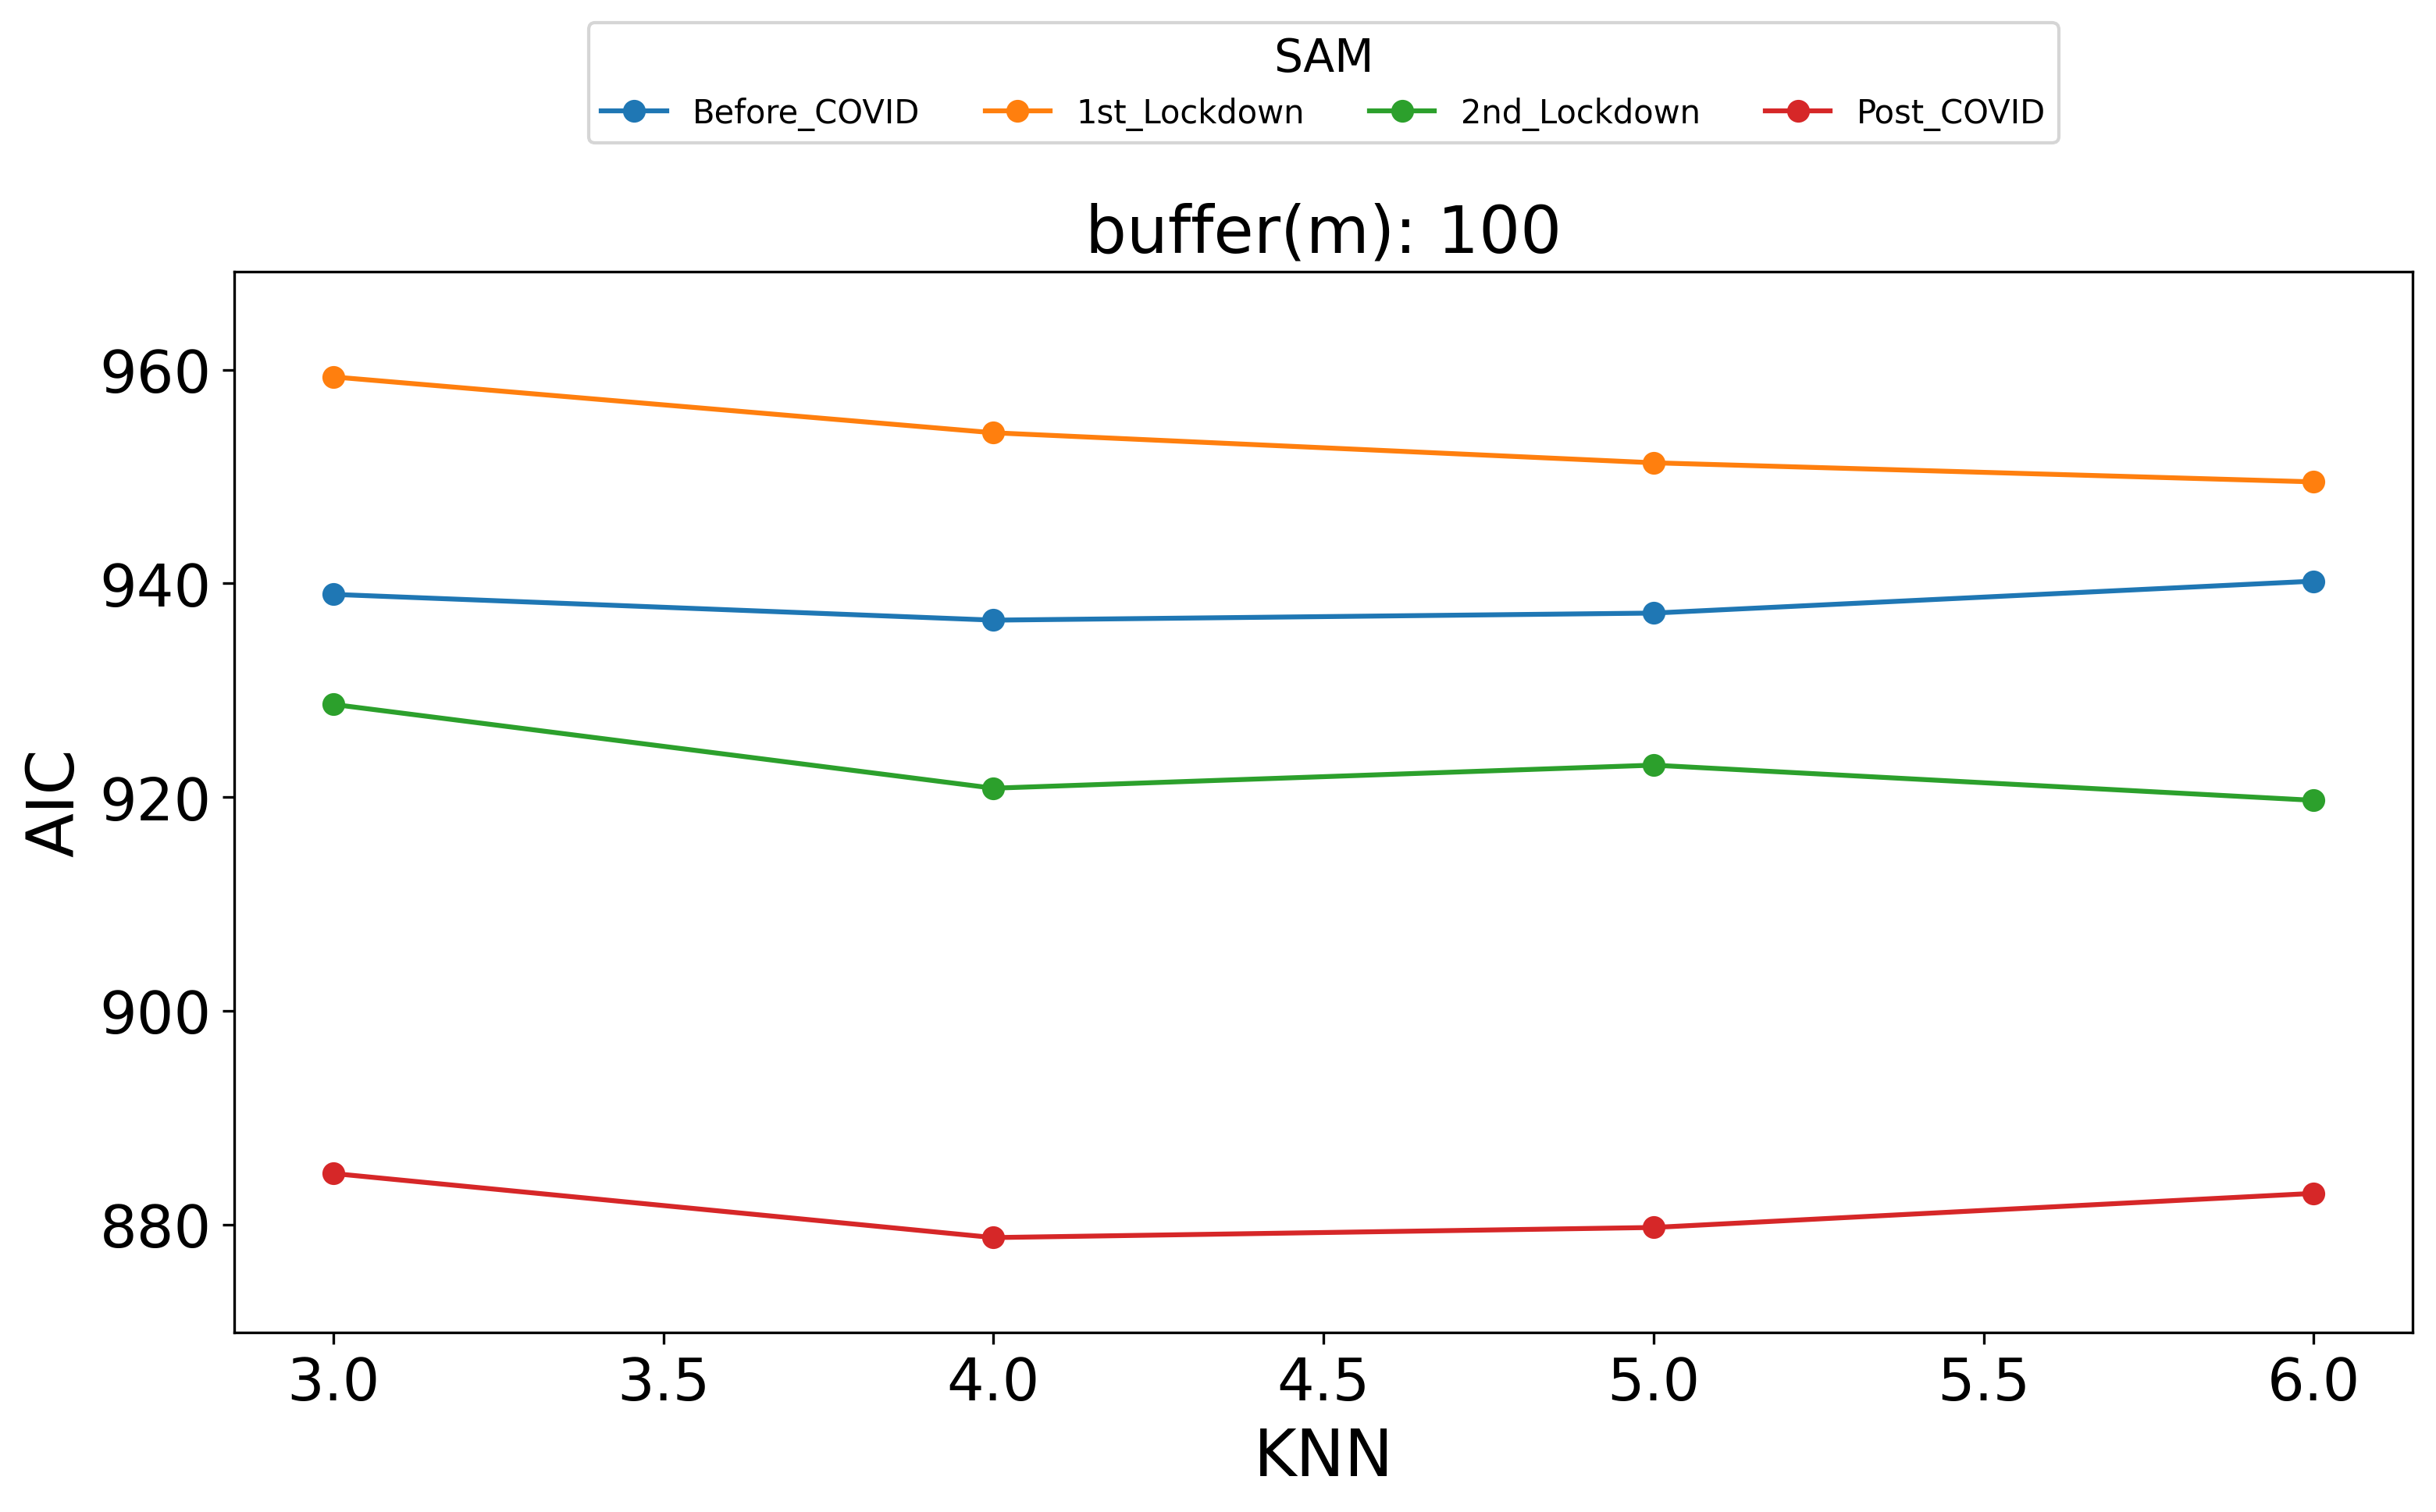

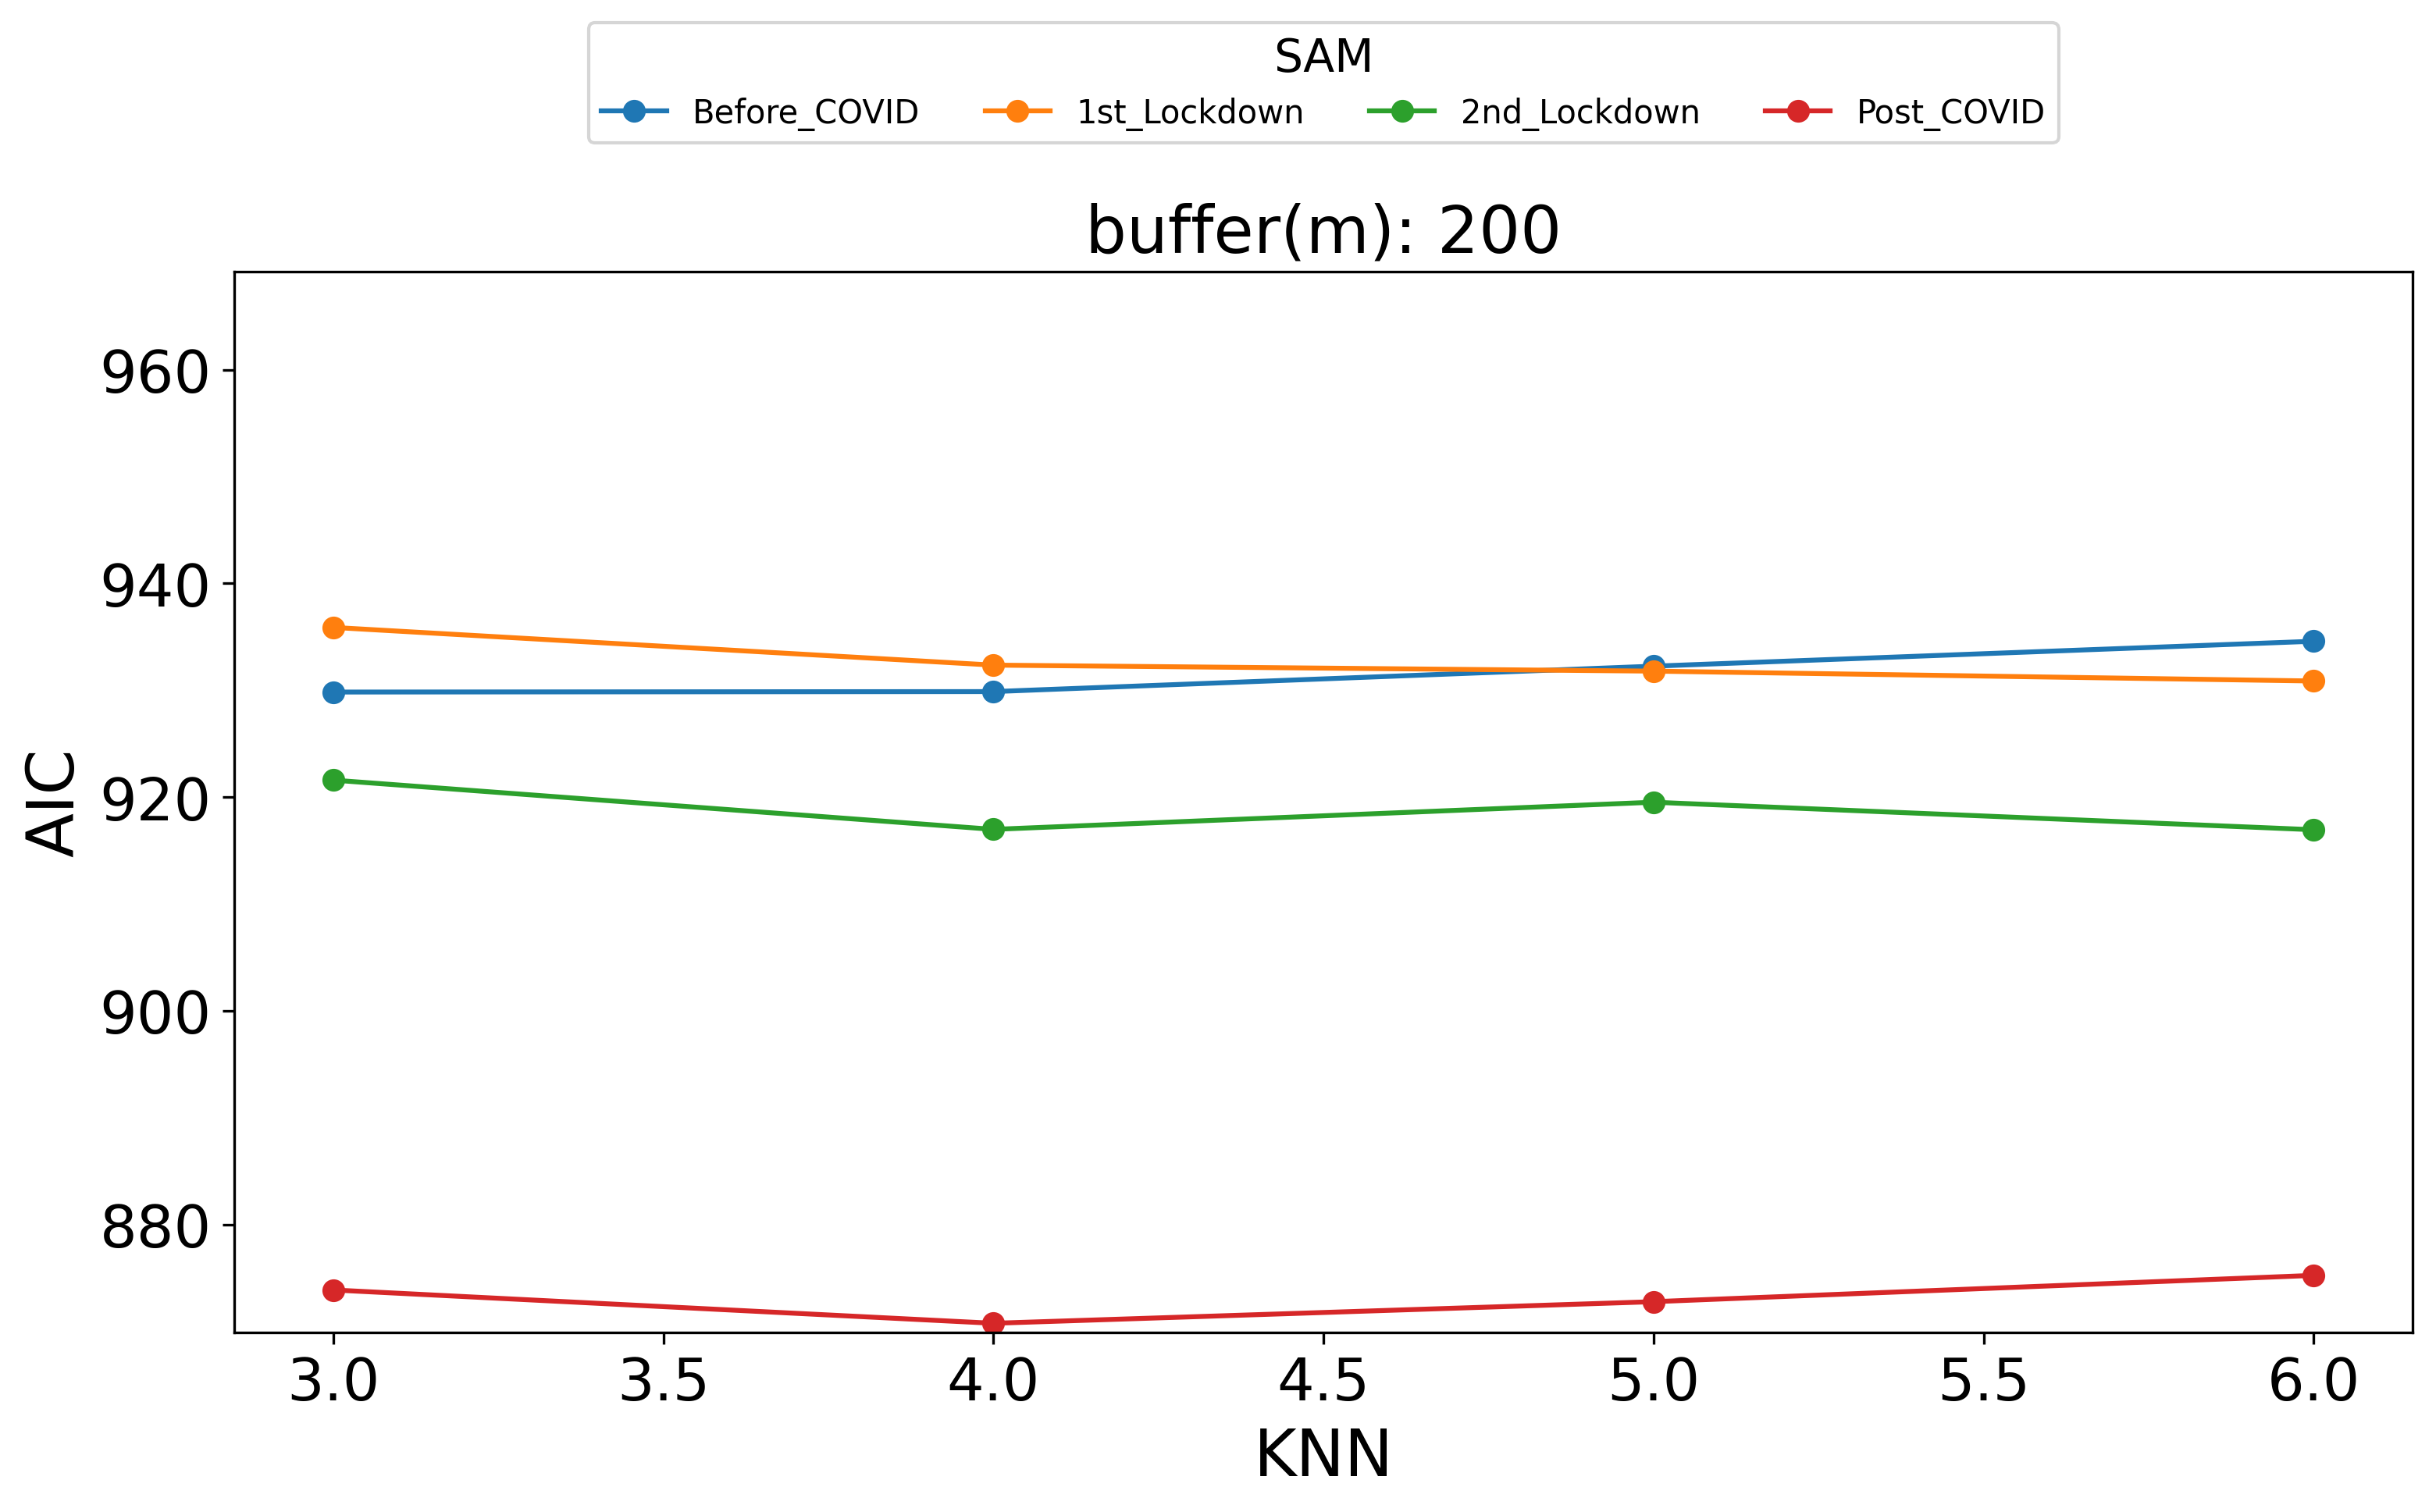

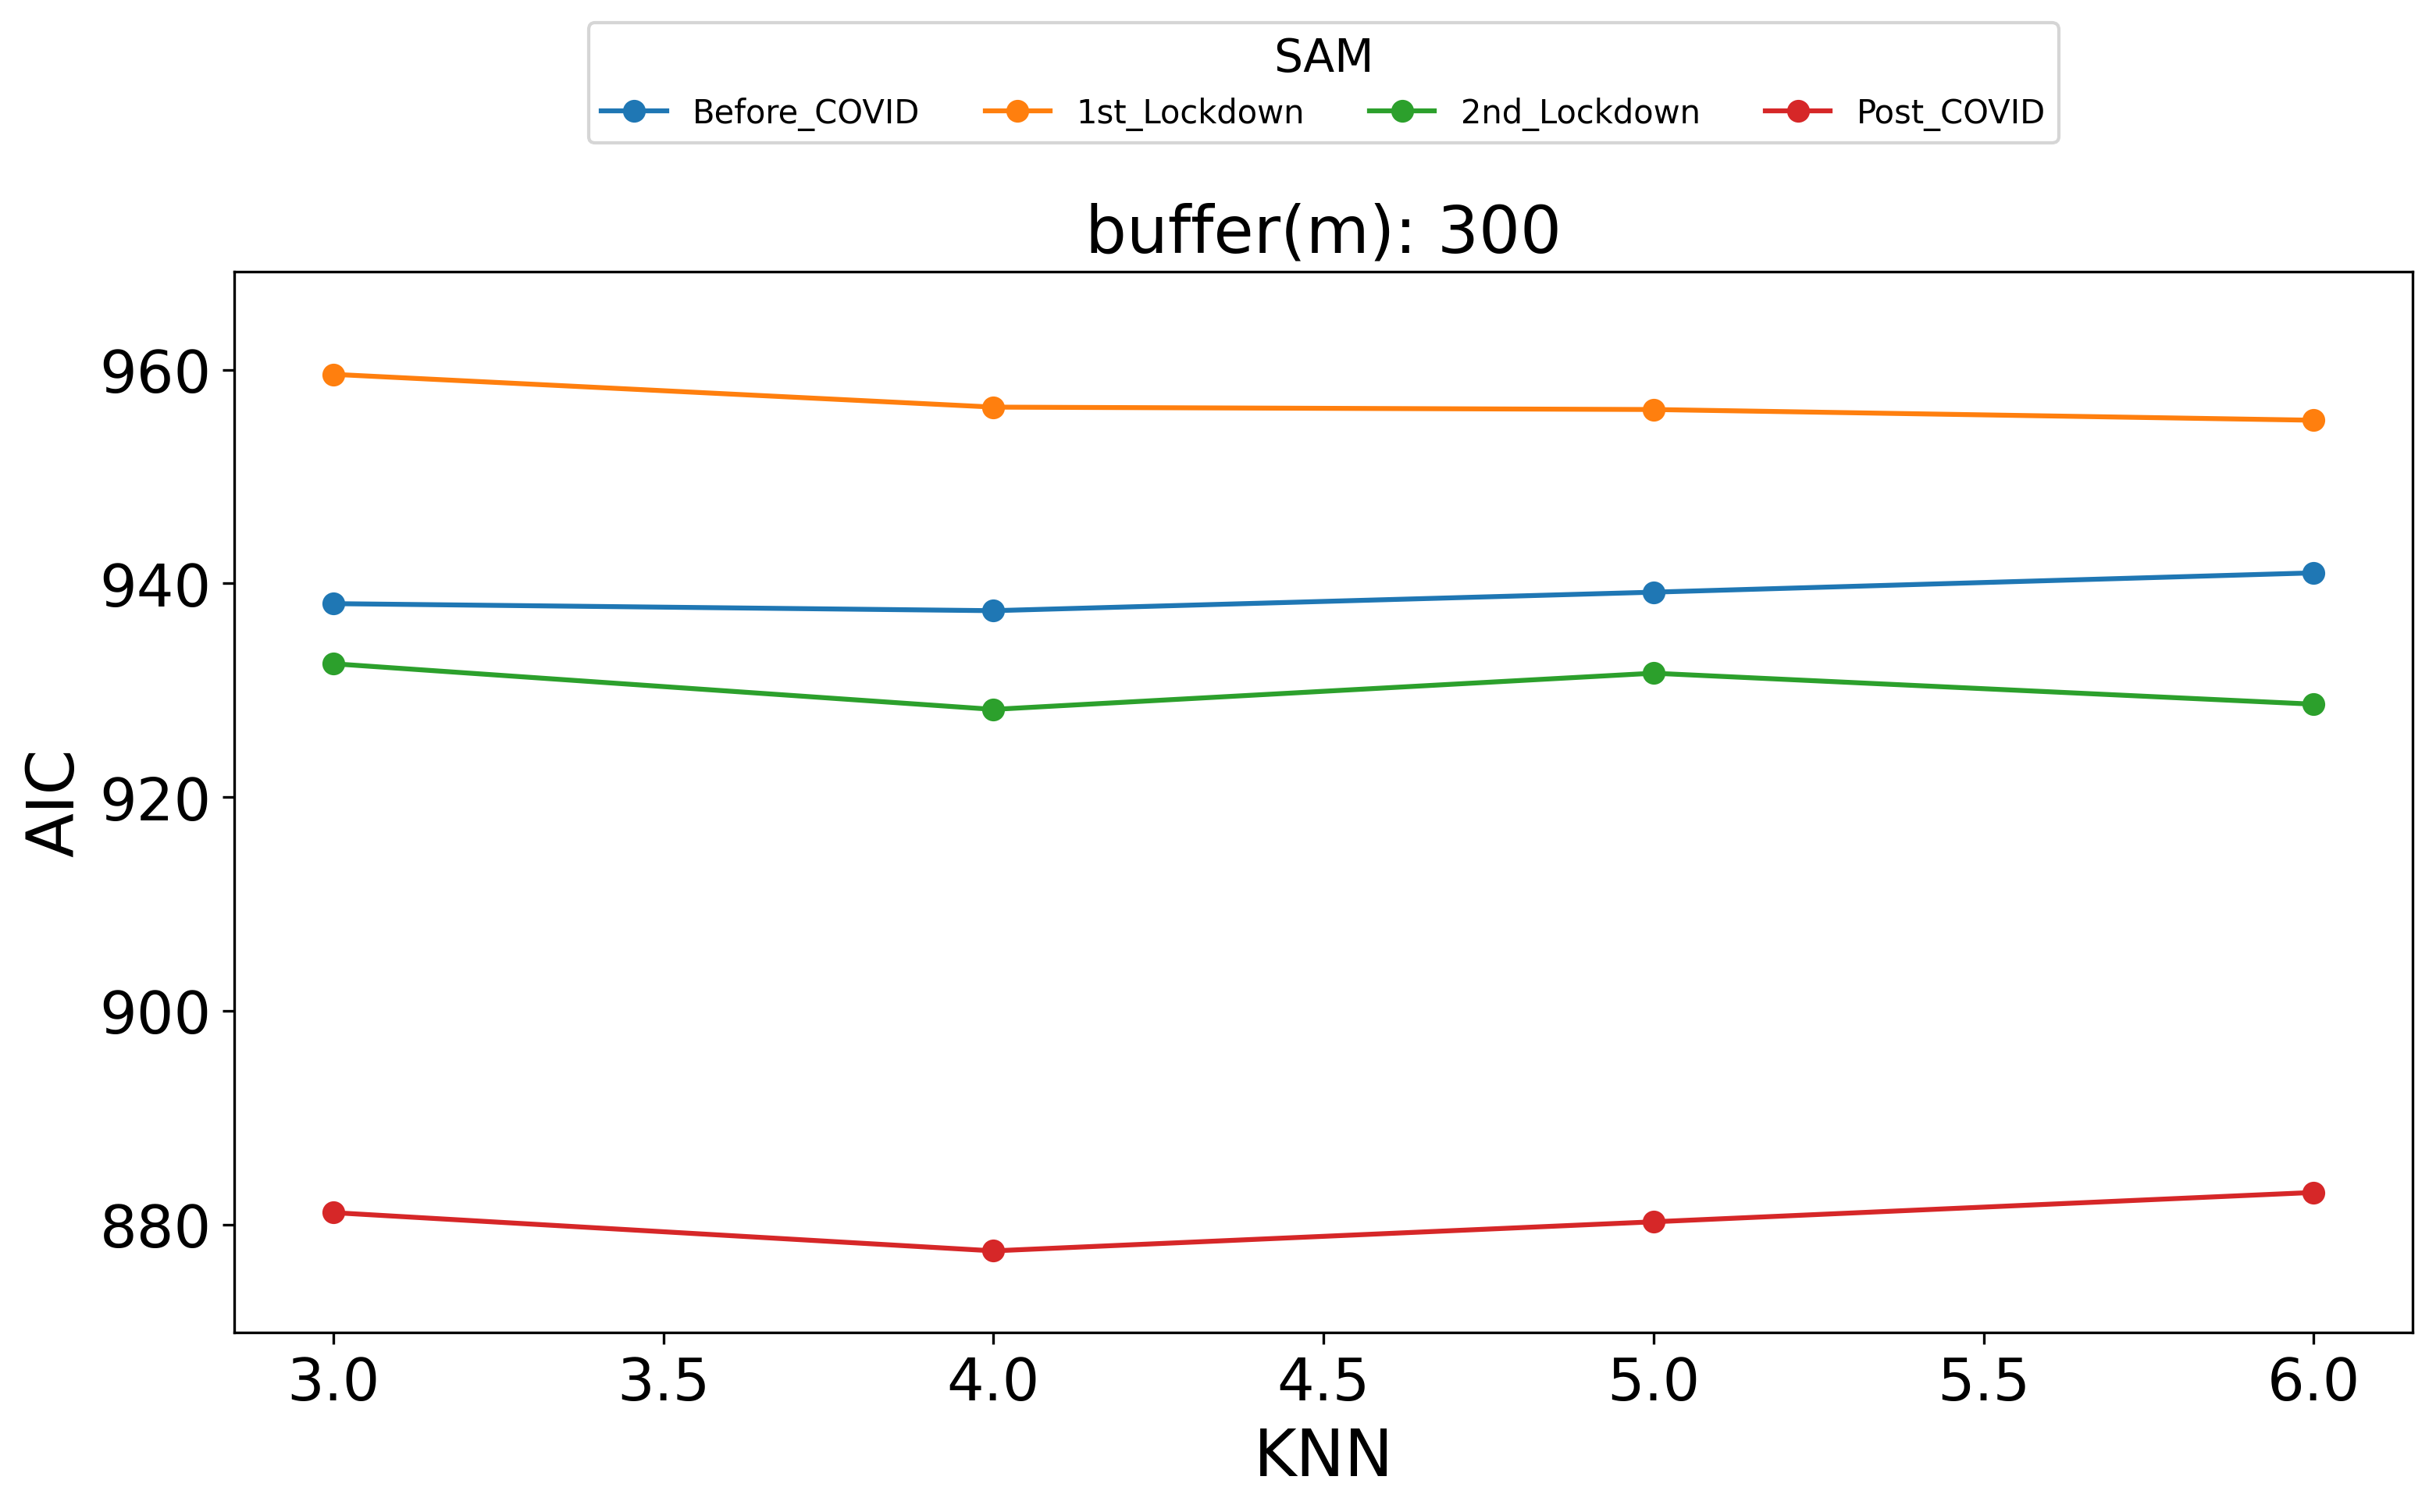

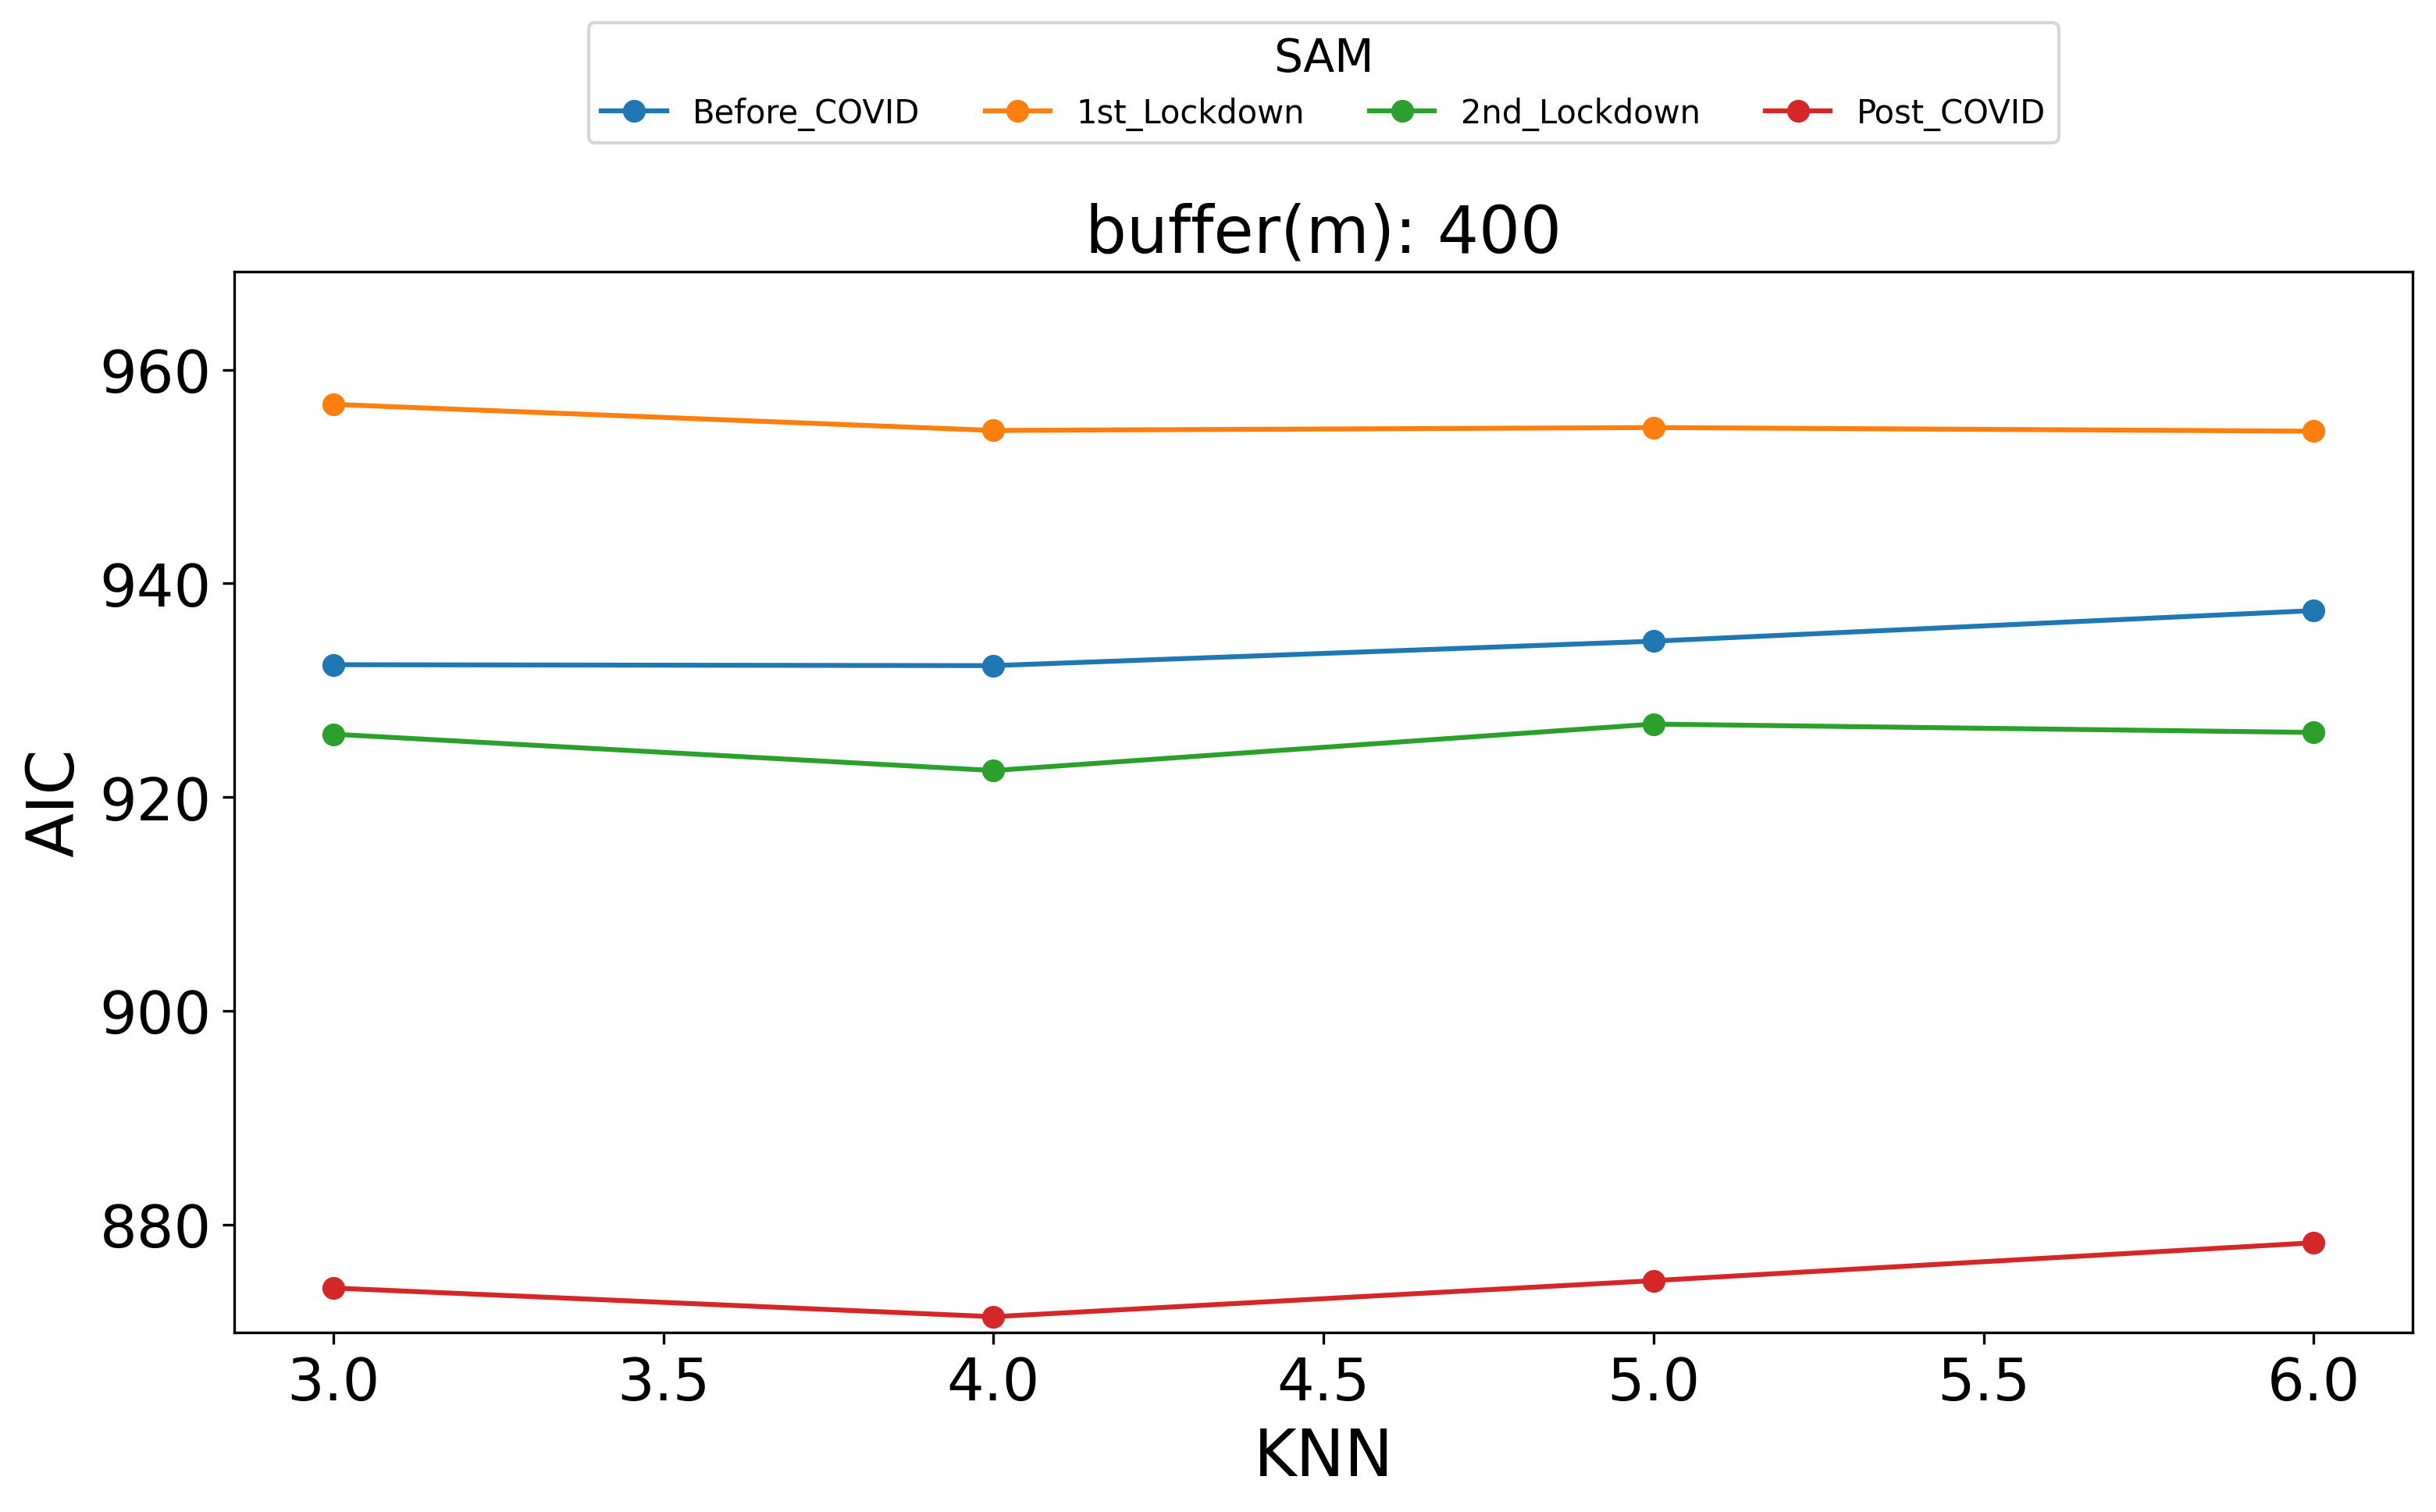

In [35]:
plot_list1, plot_list2 = split_the_df(lag_df)
plot_model_para(lag_df, plot_list2,'SAM')

## 4. Model implement

In [ ]:
ols_2 = model_results(x_200,w_4,'ols')
err_2 = model_results(x_200,w_4,'spat_err')
lag_2 = model_results(x_200,w_4,'spat_lag')
dur_2 = model_results(x_200,w_4,'spat_dur')

In [ ]:
ols_2[1]

ols,Before_COVID,1st_Lockdown,2nd_Lockdown,Post_COVID
Observed I,0.07935,0.08701,0.15742,0.1174
Expected I,-0.00189,-0.00189,-0.00189,-0.00189
P-value of I,0.00208**,0.00086***,0.0***,1e-05***
Z-value of I,2.86542,3.1358,5.61923,4.20759
LM test for spatial error model,7.75673,9.32789,30.53091,16.98033
P-value of LM test spatial error model,0.00535**,0.00226**,0.0***,4e-05***
LM test for spatial lag model,15.90551,15.60081,46.17467,31.30446
P-value of LM test spatial lag model,7e-05***,8e-05***,0.0***,0.0***
Robust LM test for spatial error model,9.60506,4.02613,7.54098,14.65294
P-value of Robust LM test spatial error model,0.00194**,0.0448*,0.00603**,0.00013***


In [ ]:
display(err_2[1].T[['AIC','Pseudo R-squared','Log-Likelihood']].T,
        lag_2[1].T[['AIC','Pseudo R-squared','Log-Likelihood']].T,
        dur_2[1].T[['AIC','Pseudo R-squared','Log-Likelihood']].T)

spat_err,Before_COVID,1st_Lockdown,2nd_Lockdown,Post_COVID
AIC,917.394360,937.816090,910.248670,863.866490
Pseudo R-squared,0.194090,0.174910,0.192440,0.176910
Log-Likelihood,-425.697180,-435.908050,-422.124340,-398.933240


spat_lag,Before_COVID,1st_Lockdown,2nd_Lockdown,Post_COVID
AIC,918.933320,936.738360,910.831450,863.871140
Pseudo R-squared,0.216550,0.198240,0.256860,0.229060
Log-Likelihood,-425.466660,-434.369180,-421.415730,-397.935570


spat_dur,Before_COVID,1st_Lockdown,2nd_Lockdown,Post_COVID
AIC,956.092930,962.764850,934.133550,888.776960
Pseudo R-squared,0.252810,0.250110,0.305420,0.277720
Log-Likelihood,-412.046460,-415.382430,-401.066770,-378.388480


### 4.1 Select the significant results

In [ ]:
def sig_df(model_result):
    reduced_df = model_result[['Before_COVID coef','1st_Lockdown coef', '2nd_Lockdown coef', 'Post_COVID coef']]
    sig_df = reduced_df[reduced_df.sum(axis=1).str.contains(r'\*')]
    return sig_df

In [ ]:
sig_df(ols_2[0])

,Before_COVID coef,1st_Lockdown coef,2nd_Lockdown coef,Post_COVID coef
CONSTANT,6.90932***,6.11492***,6.44761***,6.54497***
Public Infrastructure_200,-0.14827**,-0.1279*,-0.15595**,-0.1495**
Education and Health_200,-0.0766**,-0.09242***,-0.06097*,-0.05156*
Transport_200,0.10246*,0.08522,0.09458,0.10148*
Roads and railways_200,0.22954*,0.20312,0.28208**,0.21112*
Urban residential areas_200,0.06729*,0.01201,0.03339,0.0398
"Natural areas (Arable land, forests, herbaceous vegetation associations, pastures and water)_200",-0.04312*,-0.05473*,-0.03876,-0.04879*
male_percent_200,-0.77385*,-0.29123,-0.76897*,-0.63701
walk_percent(commute)_200,-0.15718,-0.21987*,-0.24248**,-0.24623**
motorway(km/sq.km)_200,0.02982*,0.02331,0.03021*,0.02919*
